In [178]:
import pandas as pd
from sklearn.feature_extraction import text
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
import stop_words as sw
from nltk.tokenize import word_tokenize 
from sklearn.preprocessing import Normalizer

import pandas as pd
import snscrape.modules.twitter as sc_twt
import itertools

import DBSCAN as ds
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

import wordcloud as wc

## Data Scrapping

In [179]:
def  scrape_and_save(search_str: str, file_name: str, num_tweets: int = 2000, slice: bool = True):

    scraped_tweets = sc_twt.TwitterSearchScraper(search_str).get_items()

    if(slice):
        sliced_scraped_tweets = itertools.islice(scraped_tweets, num_tweets)
        df = pd.DataFrame(sliced_scraped_tweets)
    else:
        df = pd.DataFrame(scraped_tweets)

    if df.empty == False:
        scr = pd.DataFrame.copy( df[['id', 'date', 'user', 'media', 'lang', 'content', 'hashtags', 'likeCount', 'replyCount', 'quoteCount']])

        scr['user_name'] = scr['user'].apply(lambda x: x['username'])
        scr['user_location'] =  scr['user'].apply(lambda x: x['location'])
        scr['user_isprotected'] = scr['user'].apply(lambda x: x['protected'])
        scr['user_isverified'] = scr['user'].apply(lambda x: x['verified'])

        scr = scr.drop(columns=['user'])

        print("num scraped tweets:" + str(scr.count()))
        print(scr.head(5))
        scr.to_csv(file_name)
    else:
        print("empty df")

In [180]:
# get tweets in english
from os.path import exists

tweets_file = "data/scraped_tweets.csv"
file_exists = exists(tweets_file)

if not file_exists:
    en_search = '(WorldCup OR WorldCup2022 OR FifaWorldCup) until:2022-11-10 lang:en'
    scrape_and_save(search_str = en_search, file_name = "data/scraped_tweets.csv", slice = True, num_tweets=60000)

## Data preprocessing

In [193]:
from os.path import exists

tweets_file = "data/tweets_processed.csv"
tweets_processed_file = exists(tweets_file)
tweets_processed_file

False

### Read data

In [195]:
if not tweets_processed_file:
    df_en_tweets = pd.read_csv("data/scraped_tweets.csv", delimiter=',')
    print(df_en_tweets.head(2))

   Unnamed: 0                   id                       date  \
0           0  1590494205247623168  2022-11-09 23:59:03+00:00   
1           1  1590494197261684737  2022-11-09 23:59:01+00:00   

                                               media lang  \
0                                                NaN   en   
1  [{'previewUrl': 'https://pbs.twimg.com/media/F...   en   

                                             content  \
0  .@MinkysHighjinks: "There can never again be a...   
1  The #LesBleus French National Team has announc...   

                                            hashtags  likeCount  replyCount  \
0                                   ['WorldCup2022']          1           0   
1  ['LesBleus', 'FIFAWorldCup', 'France', 'FIFA',...          1           0   

   quoteCount      user_name user_location  user_isprotected  user_isverified  
0           0  jftaveira1993      Portugal             False            False  
1           0   JustinSibbet        Canada           

### clean columns

#### Ensure that pl tweets in en are just in english

In [196]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets.loc[df_en_tweets['lang'] == 'en']
    df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        59263 non-null  int64 
 1   id                59263 non-null  int64 
 2   date              59263 non-null  object
 3   media             14799 non-null  object
 4   lang              59263 non-null  object
 5   content           59263 non-null  object
 6   hashtags          31367 non-null  object
 7   likeCount         59263 non-null  int64 
 8   replyCount        59263 non-null  int64 
 9   quoteCount        59263 non-null  int64 
 10  user_name         59263 non-null  object
 11  user_location     37200 non-null  object
 12  user_isprotected  59263 non-null  bool  
 13  user_isverified   59263 non-null  bool  
dtypes: bool(2), int64(5), object(7)
memory usage: 6.0+ MB


##### add new, simpler index

In [197]:
# create new index
if not tweets_processed_file:
    df_en_tweets.insert(0, 'ID', range(0, len(df_en_tweets)))
    df_en_tweets = df_en_tweets.set_index('ID')
    print(df_en_tweets.head(3))

    Unnamed: 0                   id                       date  \
ID                                                               
0            0  1590494205247623168  2022-11-09 23:59:03+00:00   
1            1  1590494197261684737  2022-11-09 23:59:01+00:00   
2            2  1590494185588551680  2022-11-09 23:58:58+00:00   

                                                media lang  \
ID                                                           
0                                                 NaN   en   
1   [{'previewUrl': 'https://pbs.twimg.com/media/F...   en   
2                                                 NaN   en   

                                              content  \
ID                                                      
0   .@MinkysHighjinks: "There can never again be a...   
1   The #LesBleus French National Team has announc...   
2   The US Men's National Team  has set it's roste...   

                                             hashtags  likeCount  replyC

In [198]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets[['lang', 'content', 'user_location']]
    print(df_en_tweets.head(3))

   lang                                            content user_location
ID                                                                      
0    en  .@MinkysHighjinks: "There can never again be a...      Portugal
1    en  The #LesBleus French National Team has announc...        Canada
2    en  The US Men's National Team  has set it's roste...  New York, NY


#### Encode location column

In [199]:
if not tweets_processed_file:
    oe = OrdinalEncoder()
    df_en_tweets['location'] = df_en_tweets['user_location']
    df_en_tweets['location'] = oe.fit_transform(np.array(df_en_tweets['location']).reshape(-1, 1))
    df_en_tweets = df_en_tweets.drop(columns = ['user_location'])
    df_en_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lang      59263 non-null  object 
 1   content   59263 non-null  object 
 2   location  37200 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.8+ MB


### Clean text content

In [200]:
if not tweets_processed_file:
    white_spaces = ["\r", "\n","\t", "    "]
    punctuation_signs = list("?:!.,;")
    special_characters = list("@#")


    df_en_tweets['content_clean_1'] = df_en_tweets['content']

    # whitespaces
    for char in white_spaces:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(char, " ")

    # quotation marks
    df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace('"', '')


    # puncuation signs
    for sign in punctuation_signs:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(sign, '')

C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\4111811798.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(sign, '')


In [201]:
if not tweets_processed_file:
    hashtag_regex = "(#)(((\S)|(\d))*)"
    tag_regex = "(@)(((\S)|(\d))*)"


    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_1'].str.replace(pat=hashtag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=tag_regex, repl= "")

C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\2733330322.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_1'].str.replace(pat=hashtag_regex, repl= "")
C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\2733330322.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=tag_regex, repl= "")


In [202]:
if not tweets_processed_file:
        import re 
        emoji_regex = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                        "]+", re.UNICODE)

        df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_2'].str.replace(pat=emoji_regex, repl= " ")

In [203]:
if not tweets_processed_file:
    df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_3'].str.replace("’s", "")
    df_en_tweets['content_clean_4'] = df_en_tweets['content_clean_3'].str.replace("'", "")
    df_en_tweets['content_clean_5'] = df_en_tweets['content_clean_4'].str.lower()
    print(df_en_tweets.head())

   lang                                            content  location  \
ID                                                                     
0    en  .@MinkysHighjinks: "There can never again be a...    7370.0   
1    en  The #LesBleus French National Team has announc...    1833.0   
2    en  The US Men's National Team  has set it's roste...    6478.0   
3    en  This has to be some sick joke now! No maddison...       NaN   
4    en  UPDATED WITH MORE QUOTES: Inter Miami defender...    5883.0   

                                      content_clean_1  \
ID                                                      
0   @MinkysHighjinks There can never again be a Wo...   
1   The #LesBleus French National Team has announc...   
2   The US Men's National Team  has set it's roste...   
3   This has to be some sick joke now No maddison ...   
4   UPDATED WITH MORE QUOTES Inter Miami defender ...   

                                      content_clean_2  \
ID                                    

#### Lemmatize

In [204]:
if not tweets_processed_file:
    lemmatizer = WordNetLemmatizer()
    stop_words_en = sw.get_stop_words(language="english")

    df_en_tweets['content_clean_6'] = df_en_tweets['content_clean_5']

    lemmatized_texts = []

    for row in df_en_tweets['content_clean_6']:
        text = row
        word_tokens = text.split(" ")

        lemmas  = []
        lemmatized_text = []

        for word in word_tokens:
            if word not in stop_words_en:
                lemmas.append(lemmatizer.lemmatize(word, pos = 'v'))

        lemmatized_text = " ".join(lemmas)

        lemmatized_texts.append(lemmatized_text)
        
    df_en_tweets['content_clean_7']= lemmatized_texts
    print(df_en_tweets.head())

   lang                                            content  location  \
ID                                                                     
0    en  .@MinkysHighjinks: "There can never again be a...    7370.0   
1    en  The #LesBleus French National Team has announc...    1833.0   
2    en  The US Men's National Team  has set it's roste...    6478.0   
3    en  This has to be some sick joke now! No maddison...       NaN   
4    en  UPDATED WITH MORE QUOTES: Inter Miami defender...    5883.0   

                                      content_clean_1  \
ID                                                      
0   @MinkysHighjinks There can never again be a Wo...   
1   The #LesBleus French National Team has announc...   
2   The US Men's National Team  has set it's roste...   
3   This has to be some sick joke now No maddison ...   
4   UPDATED WITH MORE QUOTES Inter Miami defender ...   

                                      content_clean_2  \
ID                                    

In [206]:
if not tweets_processed_file:
    df_en_tweets['text'] = df_en_tweets['content_clean_7']
    df_en = df_en_tweets[['text']]
    print(df_en.head())    

                                                 text
ID                                                   
0    can never world cup uphold basic human right ...
1    french national team announce roster         ...
2   us mens national team  set roster world cup go...
3   sick joke now maddison tomori get man now    h...
4   update quote inter miami defender deandre yedl...


In [207]:
if not tweets_processed_file:
    df_en.to_csv("data/tweets_processed.csv")

### Analyze data

In [208]:
tweets_df = pd.read_csv("data/tweets_processed.csv")
tweets_df.head()

,ID,text
0,0,can never world cup uphold basic human right ...
1,1,french national team announce roster ...
2,2,us mens national team set roster world cup go...
3,3,sick joke now maddison tomori get man now h...
4,4,update quote inter miami defender deandre yedl...


In [216]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59263 entries, 0 to 59262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      59263 non-null  int64 
 1   text    59260 non-null  object
dtypes: int64(1), object(1)
memory usage: 926.1+ KB


In [217]:
tweets_df = tweets_df.dropna()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59260 entries, 0 to 59262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      59260 non-null  int64 
 1   text    59260 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [218]:
def words_per_sample(list_of_texts: list):
    
    num_words = [len(s.split(' ')) for s in list_of_texts]
    return np.median(num_words)

def plot_sample_length_distr(sample_texts):
    """Plots the sample length distribution.
    """

    num_words = [len(s.split()) for s in sample_texts]
    plt.hist(num_words, 50)
    plt.xlabel('Length of a sample [words]')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [219]:
words_per_sample = words_per_sample(tweets_df["text"])
print(f"\n Median number of words per sample: {words_per_sample}")


 Median number of words per sample: 12.0


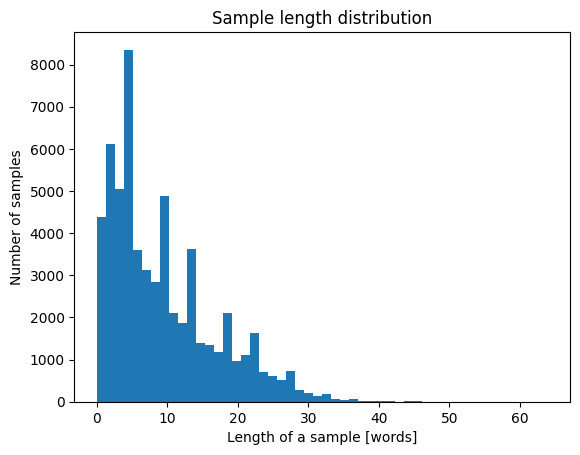

In [220]:
plot_sample_length_distr(tweets_df["text"])

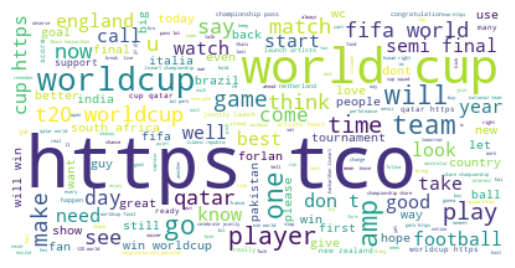

In [221]:
wordcloud = wc.WordCloud(background_color = 'white').generate(' '.join(tweets_df["text"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Tokenize

In [222]:
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
import torch

In [223]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [224]:
df_en['tokenized'] = ''
df_en['tokens'] = ''
df_en['attention_mask'] = ''

C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\1426304370.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['tokenized'] = ''
C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\1426304370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['tokens'] = ''
C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\1426304370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [225]:
tokenized_data = tokenizer(df_en["text"].values.tolist(), padding=True, truncation=True)
tokenized_data[0]

Encoding(num_tokens=116, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [226]:
i = 0
for row in df_en.itertuples():

    df_en['tokenized'][i] = tokenized_data[i].ids
    df_en['tokens'][i] = tokenized_data[i].tokens
    df_en['attention_mask'][i] = tokenized_data[i].attention_mask
    i = i +1

C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\1022806574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['tokenized'][i] = tokenized_data[i].ids
C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\1022806574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['tokens'][i] = tokenized_data[i].tokens
C:\Users\kasia\AppData\Local\Temp\ipykernel_7616\1022806574.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_en['atte

In [227]:
df_en.head()

,text,tokenized,tokens,attention_mask
ID,,,,
0,can never world cup uphold basic human right ...,"[0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...","[<s>, can, never, world, cup, uphold, basic, h...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,french national team announce roster ...,"[0, 2417, 2124, 2140, 14974, 9242, 16774, 1017...","[<s>, french, national, team, announce, roster...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,us mens national team set roster world cup go...,"[0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...","[<s>, us, men, ##s, national, team, set, roste...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,sick joke now maddison tomori get man now h...,"[0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...","[<s>, sick, joke, now, mad, ##dis, ##on, tom, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,update quote inter miami defender deandre yedl...,"[0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...","[<s>, update, quote, inter, miami, defender, d...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [228]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59262
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            59263 non-null  object
 1   tokenized       59263 non-null  object
 2   tokens          59263 non-null  object
 3   attention_mask  59263 non-null  object
dtypes: object(4)
memory usage: 4.3+ MB


In [229]:
df_en = df_en[df_en['tokens'].apply(lambda x: len(x) > 3)]
df_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59263 entries, 0 to 59262
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            59263 non-null  object
 1   tokenized       59263 non-null  object
 2   tokens          59263 non-null  object
 3   attention_mask  59263 non-null  object
dtypes: object(4)
memory usage: 2.3+ MB


In [230]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tokenized_texts = df_en['tokens'].values.tolist()
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_texts)]
tagged_data[0:2]

[TaggedDocument(words=['<s>', 'can', 'never', 'world', 'cup', 'uphold', 'basic', 'human', 'right', 'put', 'athletes', 'whose', 'job', 'place', 'work', 'in', '##vid', '##ious', 'position', 'fear', 'identity', 'https', '/', '/', 'tc', '##o', '/', 'oz', '##s', '##np', '##n', '##j', '##1', '##sg', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

In [231]:
model = Doc2Vec(vector_size = 100, window = 2, min_count = 1, epochs = 100)

In [232]:
model.build_vocab(tagged_data)

In [234]:
from os.path import exists

model_file = "d2v.model"
file_exists = exists(model_file)

if file_exists:
    model = Doc2Vec.load(model_file)
else:
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_file)

In [235]:
embeddings = [model.infer_vector(d) for i, d in enumerate(tokenized_texts)]

In [236]:
embeddings[0]

array([ 0.12351871, -0.72600454,  1.0137001 ,  1.645691  , -0.4136462 ,
        1.5755887 , -0.20661323,  0.1633672 , -0.31664526,  1.19055   ,
       -0.4802718 , -0.2822951 ,  0.5679989 ,  0.25177538,  0.02617934,
        1.4620224 , -1.0050402 , -0.9366894 ,  1.6939402 ,  0.4248427 ],
      dtype=float32)

In [237]:
df_en['embeddings'] = embeddings

In [238]:
df_en.head()

,text,tokenized,tokens,attention_mask,embeddings
ID,,,,,
0,can never world cup uphold basic human right ...,"[0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...","[<s>, can, never, world, cup, uphold, basic, h...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.123518705, -0.72600454, 1.0137001, 1.645691..."
1,french national team announce roster ...,"[0, 2417, 2124, 2140, 14974, 9242, 16774, 1017...","[<s>, french, national, team, announce, roster...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.43206975, -0.25767955, 0.014594755, -0.1367..."
2,us mens national team set roster world cup go...,"[0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...","[<s>, us, men, ##s, national, team, set, roste...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.026873438, 1.2682123, -0.8915063, 0.68189,..."
3,sick joke now maddison tomori get man now h...,"[0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...","[<s>, sick, joke, now, mad, ##dis, ##on, tom, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1.1186091, -0.7460804, 0.4529112, 0.10139532,..."
4,update quote inter miami defender deandre yedl...,"[0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...","[<s>, update, quote, inter, miami, defender, d...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.92758685, -0.5923195, 0.3079923, -0.6004851..."


## DBSCAN

### find optimal parameters

In [239]:
# experimental

data = pd.DataFrame(df_en['embeddings'])
data.head()

,embeddings
ID,
0,"[0.123518705, -0.72600454, 1.0137001, 1.645691..."
1,"[0.43206975, -0.25767955, 0.014594755, -0.1367..."
2,"[-0.026873438, 1.2682123, -0.8915063, 0.68189,..."
3,"[1.1186091, -0.7460804, 0.4529112, 0.10139532,..."
4,"[0.92758685, -0.5923195, 0.3079923, -0.6004851..."


In [240]:
df = data['embeddings'].apply(pd.Series)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ID,,,,,,,,,,,,,,,,,,,,
0,0.123519,-0.726005,1.013700,1.645691,-0.413646,1.575589,-0.206613,0.163367,-0.316645,1.190550,-0.480272,-0.282295,0.567999,0.251775,0.026179,1.462022,-1.005040,-0.936689,1.693940,0.424843
1,0.432070,-0.257680,0.014595,-0.136759,0.768741,1.134425,0.808421,-0.201994,-0.964450,0.249001,-0.208301,0.273708,-0.286648,0.549587,0.275151,0.133640,-0.044052,-0.457966,0.149543,-0.743753
2,-0.026873,1.268212,-0.891506,0.681890,1.466648,1.580708,0.392068,-0.276210,-0.130372,0.380669,0.755342,-1.143569,-0.281389,0.510848,-0.910547,0.214975,0.518266,-0.984101,-0.681537,-0.089461
3,1.118609,-0.746080,0.452911,0.101395,0.220721,0.065409,0.741650,-0.293215,-0.305232,0.519174,0.128713,-0.044477,-0.133212,0.055097,0.172459,-0.168479,0.276495,-0.237992,0.052478,-1.061851
4,0.927587,-0.592319,0.307992,-0.600485,-0.098712,1.109547,0.427861,-0.440604,-0.758172,0.359083,-1.415684,0.431984,-1.082122,0.444933,-0.077926,0.241491,1.153260,0.228659,-0.265109,-0.331501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59258,0.372381,0.477864,0.197804,-0.147913,-0.106618,-0.258614,-0.247374,-0.661329,0.163722,0.063199,0.050101,0.269436,0.327771,-0.369893,-0.179405,-0.222697,-0.136864,-0.152073,0.082727,-0.122717
59259,0.516930,0.291951,0.679031,0.083592,-0.000963,0.065463,-0.331654,-0.229530,-0.070035,0.151972,0.016517,-0.021463,0.329418,0.502001,-0.023141,-0.207407,0.200727,0.113997,0.214197,-0.208863
59260,0.315022,0.773092,0.431898,-0.305514,0.381487,-0.476235,-0.409674,0.168573,0.264267,0.399412,-0.654288,-1.006573,-0.072982,-0.306632,-0.137267,0.520362,0.790353,0.274612,-0.023427,0.168495


In [241]:
num_features = df.shape[1]
num_features

20

In [257]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

min_pts = 2*num_features
n_neighbors = min_pts 
n_neighbors = min_pts
#n_neighbors=min_pts-1

#59262 - last row id
df_cut = df[40000:59263]
df_cut.info()

df = df_cut

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19263 entries, 40000 to 59262
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       19263 non-null  float32
 1   1       19263 non-null  float32
 2   2       19263 non-null  float32
 3   3       19263 non-null  float32
 4   4       19263 non-null  float32
 5   5       19263 non-null  float32
 6   6       19263 non-null  float32
 7   7       19263 non-null  float32
 8   8       19263 non-null  float32
 9   9       19263 non-null  float32
 10  10      19263 non-null  float32
 11  11      19263 non-null  float32
 12  12      19263 non-null  float32
 13  13      19263 non-null  float32
 14  14      19263 non-null  float32
 15  15      19263 non-null  float32
 16  16      19263 non-null  float32
 17  17      19263 non-null  float32
 18  18      19263 non-null  float32
 19  19      19263 non-null  float32
dtypes: float32(20)
memory usage: 1.6 MB


In [258]:

neigbours = NearestNeighbors(n_neighbors=n_neighbors).fit(pd.DataFrame(df))
# Find the k-neighbors of a point
neigh_dist, neigh_ind = neigbours.kneighbors(df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

In [259]:
sort_neigh_dist

array([[0.00000000e+00, 4.25082217e-02, 5.49023359e-02, ...,
        8.43272750e-02, 8.43406594e-02, 8.46477827e-02],
       [0.00000000e+00, 4.25082217e-02, 5.49910373e-02, ...,
        8.47526936e-02, 8.49495749e-02, 8.54265428e-02],
       [0.00000000e+00, 4.27758917e-02, 5.55582819e-02, ...,
        8.48695631e-02, 8.50409181e-02, 8.54772004e-02],
       ...,
       [1.68587394e-07, 5.48808246e+00, 5.91051575e+00, ...,
        7.13136355e+00, 7.14278668e+00, 7.18032479e+00],
       [1.68587394e-07, 6.22591183e+00, 6.23587515e+00, ...,
        7.15577396e+00, 7.17085688e+00, 7.18803576e+00],
       [1.68587394e-07, 6.42326485e+00, 6.48792113e+00, ...,
        7.18322308e+00, 7.19796389e+00, 7.20782145e+00]])

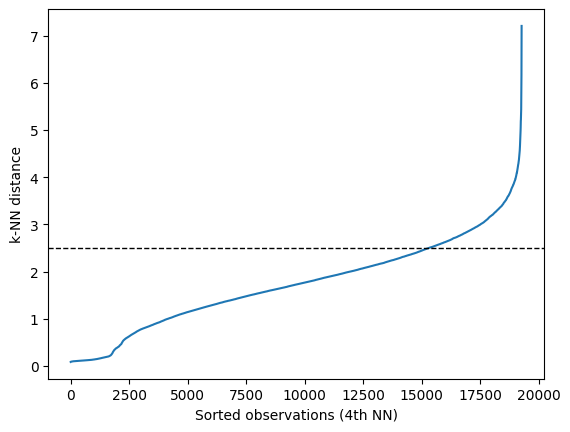

In [262]:
k_dist = sort_neigh_dist[:, n_neighbors-1]
plt.plot(k_dist)
plt.axhline(y=2.5, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [263]:
print(f"num features is: {df.shape[1]}")

num features is: 20


In [264]:
# from plot
eps = 2.5

print(f"min_pts parameter is: {min_pts}, epsilon parameter is: {eps}")

min_pts parameter is: 40, epsilon parameter is: 2.5


### apply dbscan

In [265]:
data_arr = np.array(df_cut)
data_arr[0]

array([-0.29598308,  0.20448124, -0.15826064, -0.29360926, -0.28899264,
       -0.39456028, -0.16071215, -0.6982731 , -0.01681617, -0.68902093,
        0.77019495,  0.96800315,  0.48657897, -0.4064826 ,  0.34917635,
       -0.08574778, -0.3676097 , -0.20740047, -0.07177794, -0.31257045],
      dtype=float32)

In [266]:
result = ds.dbscan(db_values = data_arr, eps= eps, min_points= min_pts)
result

([1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  -1,
  1,
  1,
  1,


In [267]:
df_result = pd.DataFrame(result) 
df_result

,0,1,2,3,4,5,6,7,8,9,...,19253,19254,19255,19256,19257,19258,19259,19260,19261,19262
0,1,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
result_exp = ds.dbscan(db_values = data_arr, eps= 4, min_points= min_pts)
result_exp

In [ ]:
df_result = pd.DataFrame(result_exp) 
df_result